# Demanda de Energía en Tenerife - PARTE 1

### Estudio de series temporales y forecasting

Jose Luis Quintero García, Marzo 2023

Este estudio consiste en la recopilación de datos de demanda energética en Tenerife desde 2013 hasta 2023 y en el tratamiento de la serie de datos resultante para terminar realizando un forecast de deicho consumo.

* Los datos recogidos de la web https://demanda.ree.es/ son de demanda energética en Tenerife para cada 5 minutos. Se aprovechará para estudiar la diferencia de estudiar estos datos con este nivel de agregación o datos con medias para cada hora y analizar el nivel de exactitud del forecast para previsiones de 1 semana.

* Se analizará el dataset tal cual ha sido recogido de la web y, por otro lado, se estudiará con la adición de datos exógenos como festivos o fines de semana, para ver la diferencia en el forecast a 1 semana.

* En una primera parte, se usarán métodos clásicos, como SARIMA, mientras que en una segunda paete, usaremos métodos clásicos de machine learning.

## Importación de librerías y carga del dataset

In [2]:
import pandas as pd
import numpy as np

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima   

In [31]:
data5m = pd.read_csv("./demanda_energia_TF_5m.csv", index_col="fecha")
data5m.head()

,consumo
fecha,
2012-12-31 20:00,546.0
2012-12-31 20:05,546.0
2012-12-31 20:10,545.0
2012-12-31 20:15,543.0
2012-12-31 20:20,540.0


In [32]:
data5m.index

Index(['2012-12-31 20:00', '2012-12-31 20:05', '2012-12-31 20:10',
       '2012-12-31 20:15', '2012-12-31 20:20', '2012-12-31 20:25',
       '2012-12-31 20:30', '2012-12-31 20:35', '2012-12-31 20:40',
       '2012-12-31 20:45',
       ...
       '2023-03-03 01:15', '2023-03-03 01:20', '2023-03-03 01:25',
       '2023-03-03 01:30', '2023-03-03 01:35', '2023-03-03 01:40',
       '2023-03-03 01:45', '2023-03-03 01:50', '2023-03-03 01:55',
       '2023-03-03 02:00'],
      dtype='object', name='fecha', length=1079215)

In [33]:
data5m.index = pd.to_datetime(data5m.index)

In [34]:
data5m.index

DatetimeIndex(['2012-12-31 20:00:00', '2012-12-31 20:05:00',
               '2012-12-31 20:10:00', '2012-12-31 20:15:00',
               '2012-12-31 20:20:00', '2012-12-31 20:25:00',
               '2012-12-31 20:30:00', '2012-12-31 20:35:00',
               '2012-12-31 20:40:00', '2012-12-31 20:45:00',
               ...
               '2023-03-03 01:15:00', '2023-03-03 01:20:00',
               '2023-03-03 01:25:00', '2023-03-03 01:30:00',
               '2023-03-03 01:35:00', '2023-03-03 01:40:00',
               '2023-03-03 01:45:00', '2023-03-03 01:50:00',
               '2023-03-03 01:55:00', '2023-03-03 02:00:00'],
              dtype='datetime64[ns]', name='fecha', length=1079215, freq=None)

<Axes: xlabel='fecha'>

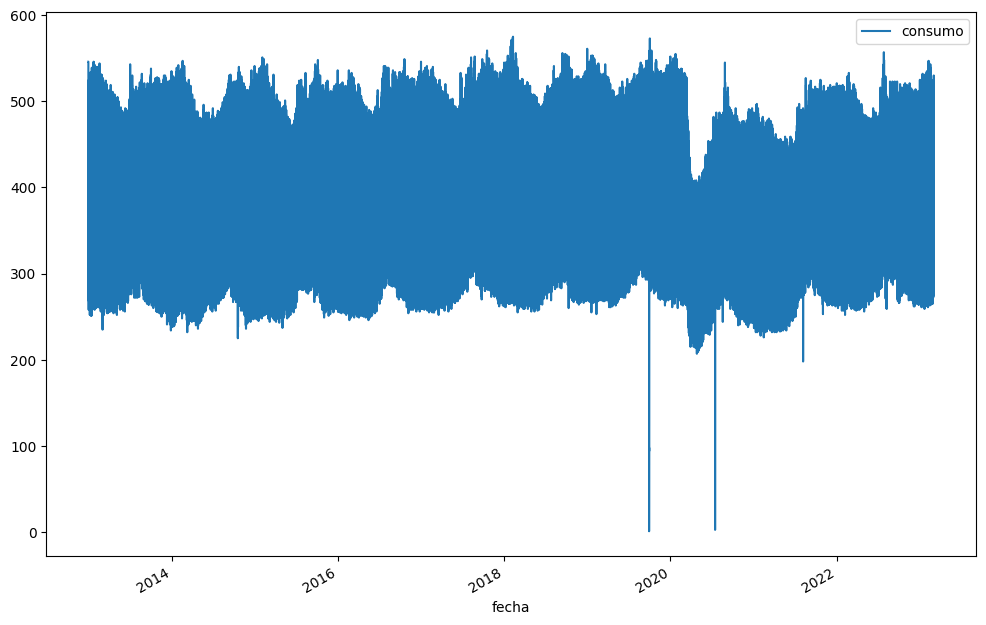

In [52]:
data5m.plot(figsize=(12,8))

## Ceros energéticos y anomalía en 2020

In [51]:
data5m.loc[data5m["consumo"]<=100].index

DatetimeIndex(['2019-09-29 13:25:00', '2019-09-29 13:30:00',
               '2019-09-29 13:35:00', '2019-09-29 13:40:00',
               '2019-09-29 13:45:00', '2019-09-29 13:50:00',
               '2019-09-29 13:55:00', '2019-09-29 14:00:00',
               '2019-09-29 14:05:00', '2019-09-29 14:10:00',
               '2019-09-29 14:15:00', '2019-09-29 14:20:00',
               '2019-09-29 14:35:00', '2019-09-29 14:40:00',
               '2019-09-29 14:45:00', '2019-09-29 14:50:00',
               '2019-09-29 14:55:00', '2019-09-29 15:00:00',
               '2019-09-29 15:05:00', '2019-09-29 15:10:00',
               '2019-09-29 15:15:00', '2019-09-29 15:20:00',
               '2019-09-29 15:25:00', '2019-09-29 15:30:00',
               '2019-09-29 15:35:00', '2019-09-29 15:40:00',
               '2019-09-29 15:45:00', '2019-09-29 15:50:00',
               '2019-09-29 15:55:00', '2019-09-29 16:00:00',
               '2019-09-29 16:05:00', '2019-09-29 16:10:00',
               '2019-09-

Aquí tenemos la bonita oportunidad de ver los famosos dos "ceros energéticos" que hubo en Tenerife el 29/09/2019 y el 15/07/2020.

Vemos que el primero duró desde las 13:25 hasta las 18:00 y el segundo desde las 10:25 hasta las 12:20

<Axes: xlabel='fecha'>

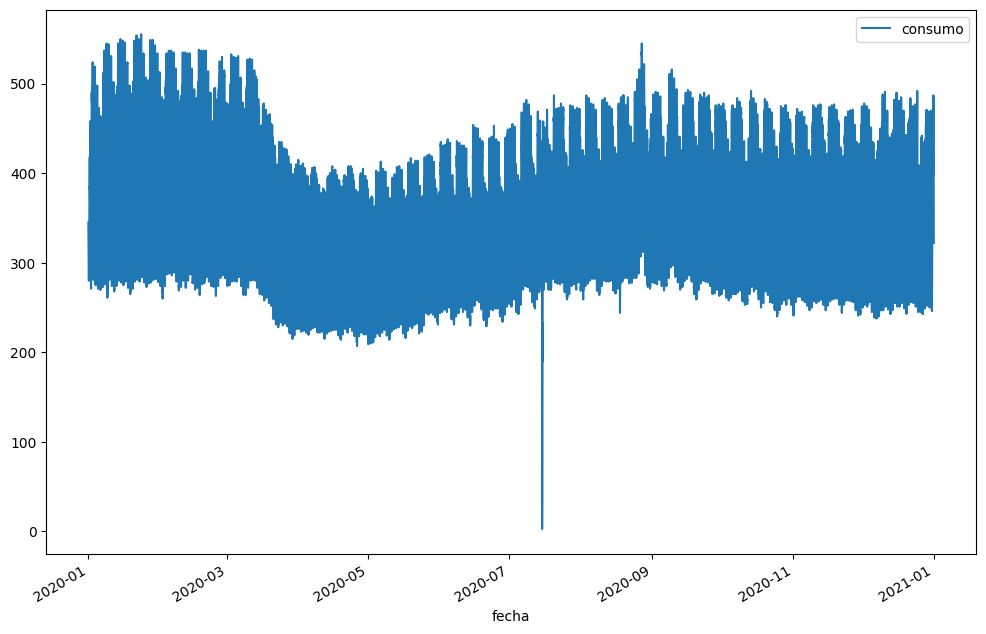

In [54]:
data5m.loc[data5m.index.year==2020].plot(figsize=(12,8))

En el año 2020, además del "cero" en julio, vemos una anomalía en el consumo desde el mes de marzo, con una pronunciada caída durante varios meses. En el año anterior, por ejemplo, no se produce este patrón:

<Axes: xlabel='fecha'>

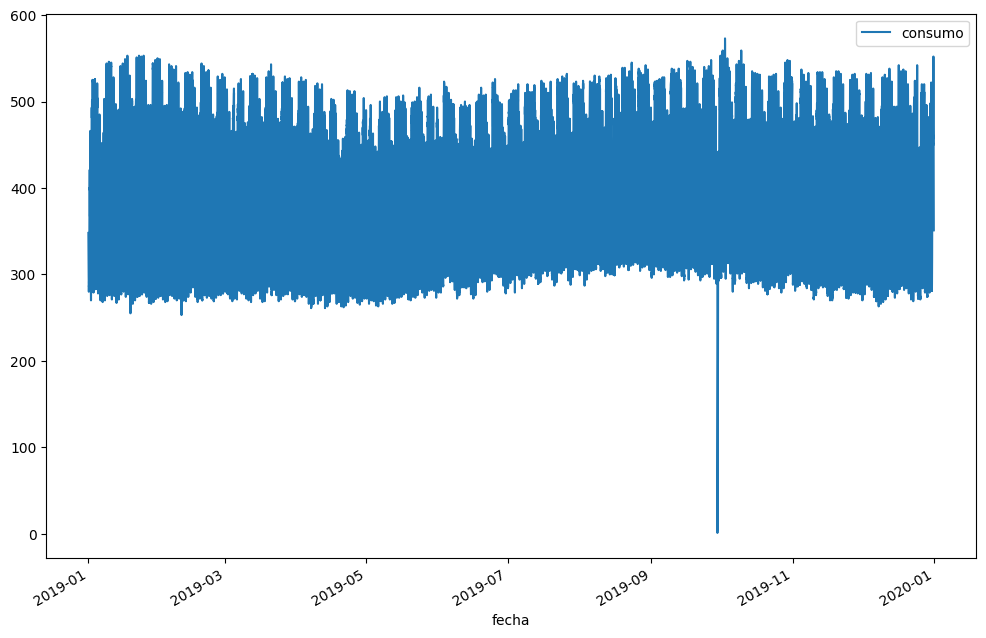

In [55]:
data5m.loc[data5m.index.year==2019].plot(figsize=(12,8))

Aquí, excepto el "cero" de septiembre, hay una serie mucho más regular que en 2021, muy parecida a la de otros años.

<Axes: xlabel='fecha'>

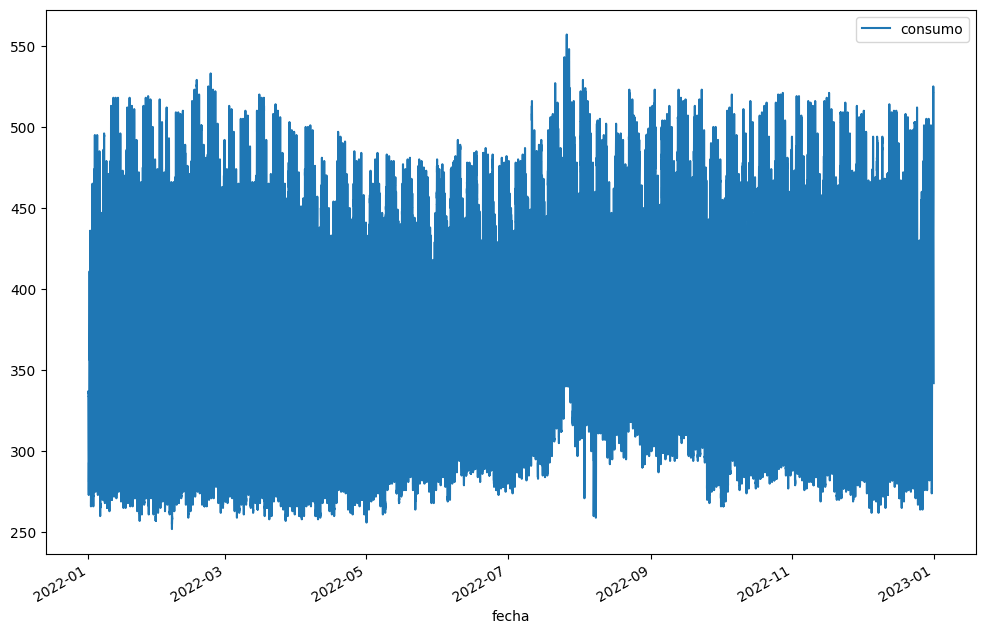

In [58]:
data5m.loc[data5m.index.year==2022].plot(figsize=(12,8))

¿Qué pasó en 2020 para explicar esa caída en el consumo frente a lo ocurrido en otros años? Por supuesto, el COVID-19. Las medidas de confinamiento decretadas en marzo de 2020 supusieron un notable descenso del consumo eléctrico, que fué recuperándose lenta y parcialmente en meses posteriores conforme se iba recuperando la actividad.